# Necessary imports

In [35]:
import (
	"fmt"
	"image/color"
	"math"
	"bytes"
	"math/rand"

	"gonum.org/v1/gonum/mat"
	"gonum.org/v1/gonum/stat/distuv"
	"gonum.org/v1/plot"
	"gonum.org/v1/plot/plotter"
	"gonum.org/v1/plot/vg"
	"gonum.org/v1/plot/palette"
	"gonum.org/v1/plot/vg/draw"
	"gonum.org/v1/plot/palette/moreland"
	"gonum.org/v1/plot"
  "gonum.org/v1/plot/plotter"
  "gonum.org/v1/plot/vg"
  "gonum.org/v1/plot/vg/draw"
  "gonum.org/v1/plot/vg/vgimg"
  "math/rand"
)

In [2]:
// Print a matrix in a nice format
func print_matrix(matrix *mat.Dense) {
	var rows, columns = matrix.Dims()
	fmt.Println("Matrix (", rows, "x", columns, "): ")
	for i := 0; i < rows; i++ {
		for j := 0; j < columns; j++ {
			fmt.Printf("%f ", matrix.At(i, j))
		}
		fmt.Println("")
	}
	fmt.Println("")
}

// Print a vector in a nice format
func print_vector(vector *mat.VecDense) {
	var rows, cols = vector.Dims()
	fmt.Println("Matrix (", rows, "x", cols, "): ")
	for i := 0; i < rows; i++ {
		fmt.Printf("%f ", vector.At(i, 0))
	}
	fmt.Println("")
}

func display_plot(p *plot.Plot) {
	var buf bytes.Buffer
	c, err := p.WriterTo(6*vg.Inch, 6*vg.Inch, "png")
	if err != nil {
			panic(err)
	}
	if _, err := c.WriteTo(&buf); err != nil {
			panic(err)
	}
	Display(display.PNG(buf.Bytes()))
}

# Problem 1

In [ ]:
func p1_f(x float64) float64 { return math.Pow(1.0 + x, -0.5) }
func p1_F(x float64) float64 { return 2.0*math.Pow(1.0 + x, 0.5)} // anti-derivative of f

func p1_trap(a float64, b float64, N int) float64 {

	// Step size (determined by # of points)
	h := (b-a) / float64(N)

	iterations := 0
	sum := 0.0
	for x_i := h; x_i < 1.0; x_i += h {

		y_i := p1_f(x_i)
		sum += y_i
		iterations++
	}
	fmt.Printf("%d\n", iterations)

	endpoint_0 := p1_f(0.0) / 2.0
	endpoint_n := p1_f(1.0) / 2.0

	Q := h * (endpoint_0 + sum + endpoint_n)
	fmt.Printf("Q = %f\n", Q)

	return Q

}


In [ ]:
func p1_monte(N int) []float64 {
	
	Y := 0.0
	areas := make([]float64, N)
	
	for i := 1; i <= N; i++ {
	
		X := rand.Float64()
		Y += p1_f(X)
	
		areas[i-1] = Y / float64(i)
	}
	
	fmt.Println(areas[N-1])
	return areas
}


In [ ]:
// Calculate errors
N := 1000
exact_value := p1_F(1.0) - p1_F(0.0)
trapezoid_error := math.Abs(exact_value - p1_trap(0.0, 1.0, N))
monte_error := math.Abs(exact_value - p1_monte(N)[N-1])

fmt.Printf("Trapezoid error: %E\n", trapezoid_error)
fmt.Printf("Monte-carlo error: %E\n", monte_error)

# Problem 2

We can use this formula to calculate the price of the option:

$E\left[\max \left(S_T-K, 0\right) \mid S 0=s\right] \approx \frac{1}{N} \sum_{n=1}^N \max \left(S_T[n]-K, 0\right)$

where 

$S_i(T)=e^{-\sigma^2 T / 2+\sigma W_i(T)} s_i$


In [7]:
// Code to create a generic stock S(T) with variance T
func W(T float64) float64 {return rand.NormFloat64() * math.Sqrt(T)}
func create_stock(T float64, K float64) func() float64 {
	return func() float64 {
		return K * math.Exp(- math.Pow(sigma, 2) * (T / 2.0) + sigma * W(T))
	}
}

// Calulate the payoff of on a call option
func payoff(stocks []func() float64) float64 {
	// Retrive largest stock
	var max_stock float64
	for _, stock := range stocks {
		max_stock = math.Max(max_stock, stock())
	}
	return math.Max(0, max_stock - K)
}

// Calculate the option price using Monte-Carlo
func monte_carlo_price(stocks []func() float64, N int) float64 {
	var sum float64
	for i := 0; i < N; i++ {
		sum += payoff(stocks)
	}
	return sum / float64(N)
}

In [9]:
T 				 := 1.0  // Variance
sigma 		 := 0.2  // Standard deviation
K 				 := 1.22 // Strike price
s 				 := K    // Condition
iterations := 1000000

// Calculate the option price using Black-Scholes
func black_scholes() float64 {
	d1 := (math.Log(s / K) + (math.Pow(sigma, 2) / 2.0) * T) / (sigma * math.Sqrt(T))
	d2 := d1 - sigma * math.Sqrt(T)
	dist := distuv.UnitNormal
	return s * dist.CDF(d1) - K * dist.CDF(d2)
}
b := black_scholes()

// Calculate the option price using Monte Carlo
stocks := make([]func() float64, 1)
stocks[0] = create_stock(T, K)
m := monte_carlo_price(stocks, iterations)

// Calculate the error
e := math.Abs(b - m)

fmt.Printf("Black-Scholes: %f \t Monte Carlo: %f \t Error: %f\n", b, m, e)

Black-Scholes: 0.097180 	 Monte Carlo: 0.097254 	 Error: 0.000074


66 <nil>

# Problem 3

$E\left[\max \left(\max \left(S_1(T), S_2(T)\right)-K, 0\right), \mid S_1(0)=s_1, S_2(0)=s_2\right] \approx \frac{1}{N} \sum_{n=1}^N \max \left(\max \left(S_1[n], S_2[n]\right)-K, 0\right)$

In [ ]:
T 				 := 1.0  // Variance
sigma 		 := 0.2  // Standard deviation
K 				 := 1.22 // Strike price
s 				 := K    // Condition
iterations := 10000

// Calculate the option price using Monte Carlo
stocks := make([]func() float64, 2)
stocks[0] = create_stock(T)
stocks[1] = create_stock(T)
m := monte_carlo_price(stocks, iterations)

fmt.Printf("Two stocks: %f\n", m)

In [ ]:
stock_count := 10

// Calculate option price for a specified number of stocks
stocks := make([]func() float64, stock_count)
for i := 0; i < stock_count; i++ {
	stocks[i] = create_stock(T)
}
m := monte_carlo_price(stocks, iterations)

fmt.Printf("%d stocks: %f\n", stock_count, m)

# Problem 4

# Problem 5



$f(m \Delta s, n \Delta t) \approx P_1(m \Delta s, n \Delta t)=f(m \Delta s, n \Delta t)+f_s(m \Delta s, n \Delta t)(s-m \Delta s)+f_t(m \Delta s, n \Delta t)(t -n \Delta t)$

${\rm FE_mat(:,i-1)} = {\rm FE_mat(:,i)} + {\rm dt} \cdot \frac{\alpha_{\rm varden}}{\Delta s^2} \cdot {\rm CD_mat} \cdot {\rm FE_mat(:,i)}$

In [58]:
K := 1.22
sigma := 0.2
T := 1.0
max_price := 2.5
timesteps := 100000
price_steps := 100


func caluclate_option_price_matrix(K float64, sigma float64, T float64, max_price float64, timesteps int, price_steps int) *mat.Dense {
	// Calculate delta t and delta s
	ds := max_price / float64(price_steps)
	dt := T / float64(timesteps)

	// Create stock price vector
	s := make([]float64, price_steps + 1)
	for i := range s {
		s[i] = float64(i) * ds
	}

	// Create time vector
	t := make([]float64, timesteps + 1)
	for i := range t {
		t[i] = float64(i) * dt
	}

	// Create option price matrix
	option_prices := mat.NewDense(price_steps + 2, timesteps, nil)

	// Set boundary conditions
	for i := 0; i < timesteps; i++ {
		option_prices.Set(0, i, K)
		option_prices.Set(price_steps + 1, i, 0)
	}

	// Set initial conditions
	for i := 1; i < price_steps+1; i++ {
		option_prices.Set(i, timesteps - 1, math.Max(K-s[i], 0))
	}

	// Calculate option prices using finite difference euler method
	for i := timesteps - 1; i > 0; i-- {
		for j := 1; j < price_steps+1; j++ {
			new_price := option_prices.At(j, i) + 1.0/2.0 * dt / math.Pow(ds ,2) * math.Pow(sigma, 2) * math.Pow(s[j], 2) * (option_prices.At(j+1, i) - 2*option_prices.At(j, i) + option_prices.At(j-1, i))
			option_prices.Set(j, i-1, new_price)
		}
	}

	return option_prices
}

f := caluclate_option_price_matrix(K, sigma, T, max_price, 500, 5)


// warning: expression returns 2 values, using only the first one: [*gonum.org/v1/plot.Plot error]


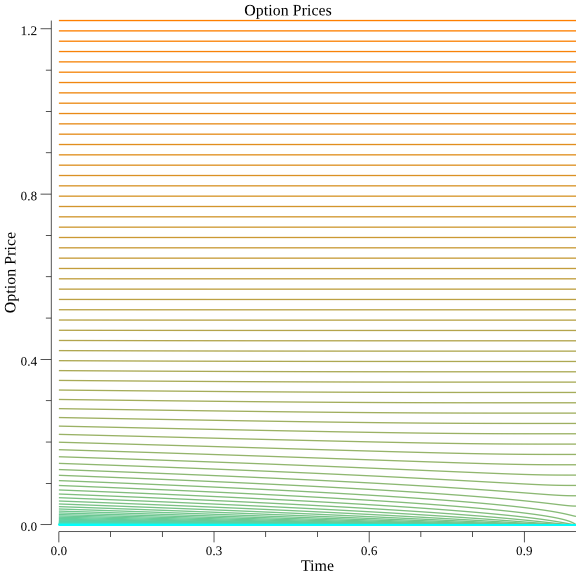

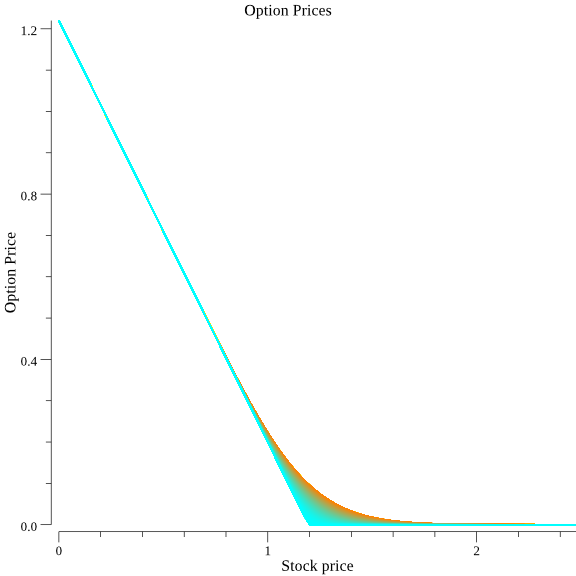

In [59]:

// Function to plot the matrix as a 2s plot where the matrix values are y values and the column index is the x value and each row index is a different line
func plot_matrix_by_time(matrix *mat.Dense, T float64) *plot.Plot {
	n, m := matrix.Dims()

	p, _ := plot.New()
	p.Title.Text = "Option Prices"
	p.X.Label.Text = "Time"
	p.Y.Label.Text = "Option Price"
	p.BackgroundColor = color.Transparent

	// Generate data points with f(x)
	for i := 0; i < n; i++ {
		pts := make(plotter.XYs, m)
		for j := 0; j < m; j++ {
			pts[j].X = T / float64(m) * float64(j)
			pts[j].Y = matrix.At(i, j)
		}

		line, err := plotter.NewLine(pts)
		if err != nil {
			panic(err)
		}
		line.Color = color.RGBA{B: uint8(255 * i / n), A: 255, R: uint8(255 - 255*i/n), G: uint8(255/2 + 255*i/n/2)}
		p.Add(line)
	}

	return p
}

func plot_matrix_by_price(matrix *mat.Dense, max_price float64) *plot.Plot {
	rows, cols := matrix.Dims()

	// Transpose matrix into a new dense matrix
	b := mat.NewDense(cols, rows, nil)
	b.Clone(matrix.T())

	p := plot_matrix_by_time(b, max_price)
	p.X.Label.Text = "Stock price"
	return p
}
	

option_prices := caluclate_option_price_matrix(K, sigma, T, max_price, timesteps, price_steps)
display_plot(plot_matrix_by_time(option_prices, T))
display_plot(plot_matrix_by_price(option_prices, max_price))



Error: [0.001287 0.000849 0.000630 0.000499 0.000411 0.000349 0.000302 0.000266 0.000237 0.000213 0.000193 0.000176 0.000162 0.000149 0.000138 0.000129 0.000120 0.000112 0.000105 0.000099 0.000093 0.000088 0.000084 0.000079 0.000075 0.000071 0.000068 0.000065 0.000062 0.000059 0.000056 0.000054 0.000051 0.000049 0.000047 0.000045 0.000043 0.000042 0.000040 0.000038 0.000037 0.000035 0.000034 0.000033 0.000031 0.000030 0.000029 0.000028 0.000027 0.000026 0.000025 0.000024 0.000023 0.000022 0.000021 0.000020 0.000020 0.000019 0.000018 0.000017 0.000017 0.000016 0.000015 0.000015 0.000014 0.000013 0.000013 0.000012 0.000012 0.000011 0.000011 0.000010 0.000010 0.000009 0.000009 0.000008 0.000008 0.000007 0.000007 0.000007 0.000006 0.000006 0.000006 0.000005 0.000005 0.000004 0.000004 0.000004 0.000003 0.000003 0.000003 0.000002 0.000002 0.000002 0.000002 0.000001 0.000001 0.000001 0.000001 0.000000]


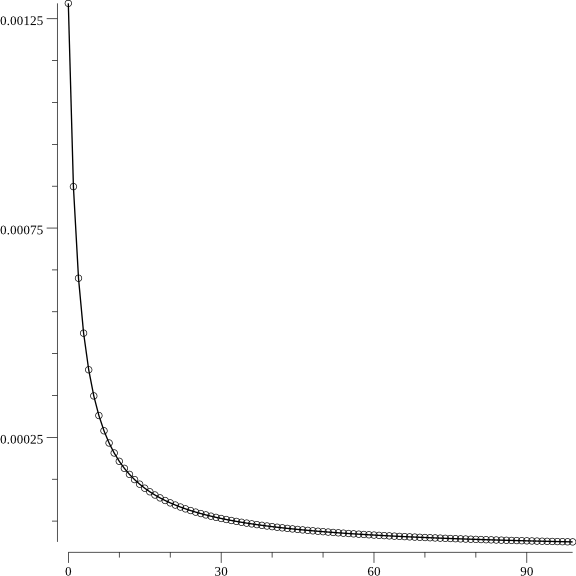

In [64]:
price_steps := 50
min_timesteps := 100
timestep_steps := 50
iterations := 100

// Calculate error for a range of timesteps
ground_truth := caluclate_option_price_matrix(K, sigma, T, max_price, min_timesteps + timestep_steps * iterations, price_steps)

errors := make([]float64, iterations)
for i := 0; i < iterations; i++ {
	timesteps := min_timesteps + i * timestep_steps
	option_prices := caluclate_option_price_matrix(K, sigma, T, max_price, timesteps, price_steps)
	e := 0.0
	for j := 1; j < price_steps; j++ {
		e += math.Pow(ground_truth.At(j, 0) - option_prices.At(j, 0), 2)
	}
	errors[i] = math.Sqrt(e)
}

fmt.Printf("Error: %f\n", errors)

// Plot the errors for a range of timestep sizes reversed order
plt, err := plot.New()
if err != nil {
	panic(err)
}

// Create points to plot
points := make(plotter.XYs, iterations)
for i := 0; i < iterations; i++ {
	points[i].X = float64(i)
	points[i].Y = errors[i]
}

// Create a line plotter with points
lpLine, lpPoints, err := plotter.NewLinePoints(points)
if err != nil {
	panic(err)
}

// Add the line and points to the plot
plt.Add(lpLine, lpPoints)

display_plot(plt)
